# Controls scoreboard

In [1]:
import tigercontrol
import jax
import jax.numpy as np
from tigercontrol.models.optimizers import *
from tigercontrol.experiments import Experiment
import jax.random as random
from tigercontrol.utils import generate_key
import matplotlib.pyplot as plt

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Simulated Data

### Setting I: Sanity Check

We initialize an LDS with A,B,C,D, for C = I, and D = 0.
m = n = 10 are the dimensions

We start with a simple sanity check, in which we generate stationary time-series data assuming the $ARMA$ model with $AR_{dyn} = [0.6, −0.5, 0.4, −0.4, 0.3]$, $MA_{dyn} = [0.3, −0.2]$, and normally distributed noise terms $w_t ∼ N (0, 0.3^2)$.

In [2]:
ar_dyn = np.array([0.6, -0.5, 0.4, -0.4, 0.3])
ma_dyn = np.array([0.3, -0.2])
mean, noise_magnitude = 0, 0.3

m = 10
n = 10
d = 10

We will compare the models ARMA-OGD and ARMA-ONS against their boosted counterparts (with $N = 5$ weak learners). Following the experiments and results of [1], our autoregressive models use history $p = 10$ and learning rate $0.00001$.

In [19]:
def get_results(steps, problem, u):
    y = []
    for i in range(steps):
        y.append(problem.step(u[i]))
    return y

In [22]:
def test_lqr_on_lds_control(steps=100, show_plot=True):
    T = steps
    n = 3 # input/control dimension
    m = 5 # output dimension
    d = 5 # hidden/state dimension (which is equal to output dimension here)
    
    problem1 = tigercontrol.problem("LDS-Control-v0")
    problem1.initialize(n, m, d, noise = 0.0)
    
    problem2 = tigercontrol.problem("LDS-Control-v0")
    problem2.initialize(n, m, d, noise = 0.2)
    
    problem3 = tigercontrol.problem("LDS-Control-v0")
    problem3.initialize(n, m, d, noise = 0.4)
    
    #### Question : Should I remove f/ make it default to None/ rename it? ######
    f = np.zeros((d,1)) # bias
    C = np.identity(d+n) # quadratic cost

    c = np.zeros((d+n, 1)) # linear cost
    x = np.ones((d,1)) # initial state

    model1 = tigercontrol.model("LQR")
    model1.initialize(problem1.A, problem1.B, f, C, c, T, x)
    
    model2 = tigercontrol.model("LQR")
    model2.initialize(problem2.A, problem2.B, f, C, c, T, x)
    
    model3 = tigercontrol.model("LQR")
    model3.initialize(problem3.A, problem3.B, f, C, c, T, x)

##    model2 = tigercontrol.model("GPC")
##    model2.initialize(A,B,...)

    u1, u2, u3 = model1.plan(), model2.plan(), model3.plan()
    y1, y2, y3 = get_results(steps, problem1, u1), get_results(steps, problem2, u2), get_results(steps, problem3, u3)
    
    if show_plot:
        plt.plot([np.linalg.norm(i) for i in y1], 'C0-', label = "noise = 0.0")
        plt.plot([np.linalg.norm(i) for i in y2], 'C1-', label = "noise = 0.2")
        plt.plot([np.linalg.norm(i) for i in y3], 'C2-', label = "noise = 0.4")
        plt.title("LQR on LDS")
        plt.legend()
        plt.show(block=False)
        plt.pause(10)
        plt.close()

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


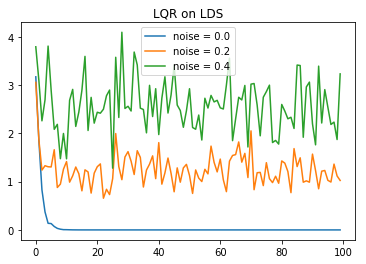

In [23]:
test_lqr_on_lds_control(steps = 100)

We can now initialize the experiment: